In [2]:
import pandas as pd

df = pd.read_csv("C:/future_intern/Task 2/all_tickets_processed_improved_v3.csv")

df.head()


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [3]:
import re

def clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]','',text)
    return text

df['clean_text'] = df['Document'].apply(clean)

df = df[['clean_text','Topic_group']]
df.dropna(inplace=True)


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['Topic_group'])

print(le.classes_)


['Access' 'Administrative rights' 'HR Support' 'Hardware'
 'Internal Project' 'Miscellaneous' 'Purchase' 'Storage']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2)
)

X_train_t = tfidf.fit_transform(X_train)
X_test_t  = tfidf.transform(X_test)


In [8]:
device = 'cuda'  # Use 'cpu' if CUDA is not available
print(f'Using device: {device}')

Using device: cuda


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr = LogisticRegression(max_iter=300)
lr.fit(X_train_t, y_train)

pred_lr = lr.predict(X_test_t)

print("Logistic Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr, target_names=le.classes_))


Logistic Accuracy: 0.8637123745819398
                       precision    recall  f1-score   support

               Access       0.92      0.87      0.89      1425
Administrative rights       0.89      0.64      0.75       352
           HR Support       0.87      0.89      0.88      2183
             Hardware       0.81      0.90      0.85      2724
     Internal Project       0.92      0.80      0.85       424
        Miscellaneous       0.84      0.83      0.83      1412
             Purchase       0.98      0.87      0.92       493
              Storage       0.95      0.83      0.89       555

             accuracy                           0.86      9568
            macro avg       0.90      0.83      0.86      9568
         weighted avg       0.87      0.86      0.86      9568



In [10]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_t, y_train)

pred_svm = svm.predict(X_test_t)

print("SVM Accuracy:", accuracy_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm, target_names=le.classes_))


SVM Accuracy: 0.8606814381270903
                       precision    recall  f1-score   support

               Access       0.90      0.90      0.90      1425
Administrative rights       0.83      0.72      0.77       352
           HR Support       0.86      0.87      0.87      2183
             Hardware       0.83      0.86      0.85      2724
     Internal Project       0.89      0.84      0.87       424
        Miscellaneous       0.83      0.82      0.82      1412
             Purchase       0.96      0.88      0.92       493
              Storage       0.92      0.87      0.90       555

             accuracy                           0.86      9568
            macro avg       0.88      0.85      0.86      9568
         weighted avg       0.86      0.86      0.86      9568



In [11]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_enc = encode(X_train)
test_enc  = encode(X_test)


In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(
    train_enc['input_ids'],
    train_enc['attention_mask'],
    torch.tensor(y_train.values, dtype=torch.long)
)

test_dataset = TensorDataset(
    test_enc['input_ids'],
    test_enc['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.long)
)


In [13]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Using device:", device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [14]:
from torch.optim import AdamW

loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

optim = AdamW(model.parameters(), lr=2e-5)

for epoch in range(5):

    model.train()
    for ids, mask, label in loader:

        ids = ids.to(device)
        mask = mask.to(device)
        label = label.to(device)

        optim.zero_grad()

        out = model(ids, attention_mask=mask, labels=label)

        loss = out.loss
        loss.backward()
        optim.step()

    # validation
    model.eval()
    preds, true = [], []

    with torch.no_grad():
        for ids, mask, label in test_loader:

            ids = ids.to(device)
            mask = mask.to(device)

            out = model(ids, attention_mask=mask)

            p = torch.argmax(out.logits, dim=1)

            preds.extend(p.cpu().numpy())
            true.extend(label.numpy())

    print("Epoch",epoch,"Acc:",accuracy_score(true,preds))


Epoch 0 Acc: 0.855873745819398
Epoch 1 Acc: 0.874059364548495
Epoch 2 Acc: 0.8802257525083612
Epoch 3 Acc: 0.8780309364548495
Epoch 4 Acc: 0.868938127090301


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("FINAL DISTILBERT PERFORMANCE\n")

print(classification_report(
    true,
    preds,
    target_names=le.classes_
))


FINAL DISTILBERT PERFORMANCE

                       precision    recall  f1-score   support

               Access       0.86      0.95      0.90      1425
Administrative rights       0.90      0.73      0.81       352
           HR Support       0.83      0.92      0.87      2183
             Hardware       0.90      0.81      0.85      2724
     Internal Project       0.89      0.89      0.89       424
        Miscellaneous       0.86      0.82      0.84      1412
             Purchase       0.93      0.89      0.91       493
              Storage       0.85      0.91      0.88       555

             accuracy                           0.87      9568
            macro avg       0.88      0.86      0.87      9568
         weighted avg       0.87      0.87      0.87      9568



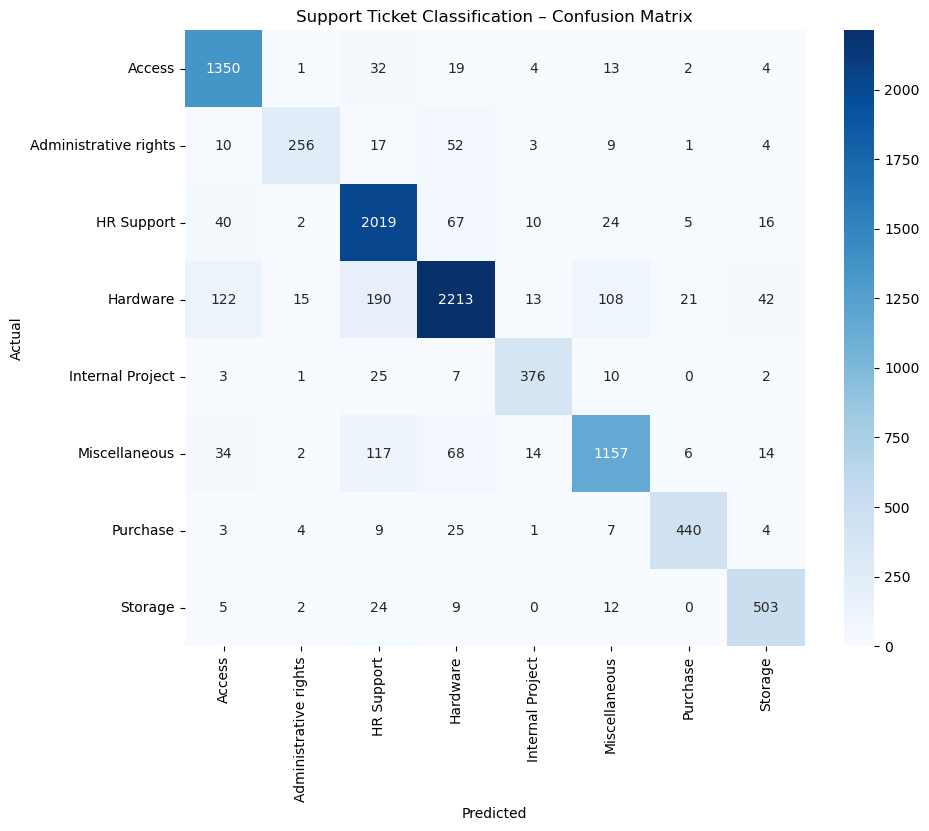

In [16]:
cm = confusion_matrix(true, preds)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title("Support Ticket Classification – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
def infer_priority(text):

    text = text.lower()

    high = ['down','failed','urgent','asap','not working',
            'crash','error','unable','critical']

    medium = ['issue','problem','reset','access',
              'help','slow','unable to']

    if any(w in text for w in high):
        return "High"

    elif any(w in text for w in medium):
        return "Medium"

    else:
        return "Low"


In [18]:
def predict_ticket(text):

    # ---- CATEGORY PREDICTION ----
    enc = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )

    ids  = enc['input_ids'].to(device)
    mask = enc['attention_mask'].to(device)

    model.eval()

    with torch.no_grad():
        out = model(ids, attention_mask=mask)

    cat_id = torch.argmax(out.logits).item()

    category = le.inverse_transform([cat_id])[0]

    # ---- PRIORITY ----
    priority = infer_priority(text)

    return {
        "Ticket": text,
        "Category": category,
        "Priority": priority
    }


In [19]:
predict_ticket("my laptop is not working and system crashed")


{'Ticket': 'my laptop is not working and system crashed',
 'Category': 'Hardware',
 'Priority': 'High'}

In [20]:
predict_ticket("please create new purchase order for monitor")


{'Ticket': 'please create new purchase order for monitor',
 'Category': 'Hardware',
 'Priority': 'Low'}

In [21]:
torch.save(model.state_dict(), "model.pt")
